# FACT + RL による新セッション訓練

このノートブックでは、訓練済みのベースモデル（session 0）を使って、新しいセッション（session 1以降）の訓練を強化学習（DQN）で行います。

## 処理フロー
1. ベースセッションで訓練済みのFACTモデルをロード
2. 新セッションのfew-shotデータをロード
3. DQNエージェントを使って新クラスを学習
4. 既存クラスの忘却を抑えながら新クラスを学習

In [22]:
import os
import sys
import random
from pathlib import Path
from typing import Optional, Tuple, Dict
from collections import deque

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm

print(f"Using torch {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Using torch 2.9.1+cu128
CUDA available: True


In [23]:
# プロジェクトルートとパスの設定
PROJECT_ROOT = Path("..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

DATA_DIR = PROJECT_ROOT / "data"
CHECKPOINT_DIR = PROJECT_ROOT / "checkpoint" / "CICIDS2017_improved"

print(f"PROJECT_ROOT: {PROJECT_ROOT}")
print(f"CHECKPOINT_DIR: {CHECKPOINT_DIR}")

PROJECT_ROOT: /home/hawk/Documents/school/test/CVPR22-Fact
CHECKPOINT_DIR: /home/hawk/Documents/school/test/CVPR22-Fact/checkpoint/CICIDS2017_improved


In [24]:
# プロジェクト固有のインポート
from dataloader.cicids2017.cicids2017 import CICIDS2017_improved
from models.fact.Network import MYNET
from utils import set_seed, load_params_yaml

In [25]:
# ハイパーパラメータ設定
SEED = 42
DEVICE = "cpu"

# データセット設定（CICIDS2017_improvedのデフォルト）
BASE_CLASS = 4
NUM_CLASSES = 10
WAY = 1  # 新セッションごとに追加されるクラス数
SHOT = 5  # Few-shotサンプル数
NUM_SESSIONS = 7  # インクリメンタルセッション数

# 訓練するセッション番号（1以降）
TARGET_SESSION = 1

# RL設定
BATCH_SIZE = 64
BUFFER_SIZE = 10000
GAMMA = 0.99
LEARNING_RATE = 1e-4
EPSILON_START = 1.0
EPSILON_END = 0.05
EPSILON_DECAY = 0.995
TARGET_UPDATE = 10
NUM_EPISODES = 500
MAX_STEPS_PER_EPISODE = 100

set_seed(SEED)
print(f"Device: {DEVICE}")
print(f"Target Session: {TARGET_SESSION}")

manual seed: 42
Device: cpu
Target Session: 1


## 1. ベースモデルのロード

session 0で訓練済みのFACTモデルをロードします。

In [26]:
# モデル設定の作成（params.yamlを使用）
params = load_params_yaml(PROJECT_ROOT / "params.yaml")
train_cfg = params.get("train", {})
create_cfg = params.get("create_sessions", {})

# YAMLの値でグローバル設定を上書き（存在する場合）
BASE_CLASS = create_cfg.get("base_class", BASE_CLASS)
NUM_CLASSES = create_cfg.get("num_classes", NUM_CLASSES)

class Args:
    def __init__(self, train_cfg, create_cfg, device):
        self.dataset = train_cfg.get("dataset", "CICIDS2017_improved")
        self.encoder = train_cfg.get("encoder", "cnn1d")
        self.base_mode = train_cfg.get("base_mode", "ft_cos")
        self.new_mode = train_cfg.get("new_mode", "avg_cos")
        self.num_classes = create_cfg.get("num_classes", NUM_CLASSES)
        self.base_class = create_cfg.get("base_class", BASE_CLASS)
        self.device = device

args = Args(train_cfg, create_cfg, DEVICE)

# FACTモデルの初期化
base_model = MYNET(args, mode=args.base_mode)
base_model = base_model.to(DEVICE)


torch.Size([6, 128])
self.dummy_orthogonal_classifier.weight initialized over.


In [27]:
checkpoint_path = CHECKPOINT_DIR / "session0_max_acc.pth"
checkpoint = torch.load(checkpoint_path, map_location=DEVICE, weights_only=False)

In [28]:
for key, value in checkpoint['params'].items():
    print(f"{key}")

module.encoder.conv1.weight
module.encoder.conv1.bias
module.encoder.bn1.weight
module.encoder.bn1.bias
module.encoder.bn1.running_mean
module.encoder.bn1.running_var
module.encoder.bn1.num_batches_tracked
module.encoder.conv2.weight
module.encoder.conv2.bias
module.encoder.bn2.weight
module.encoder.bn2.bias
module.encoder.bn2.running_mean
module.encoder.bn2.running_var
module.encoder.bn2.num_batches_tracked
module.encoder.fc1.weight
module.encoder.fc1.bias
module.encoder.fc_embedding.weight
module.encoder.fc_embedding.bias
module.encoder.fc_classifier.weight
module.encoder.fc_classifier.bias
module.fc.weight
module.dummy_orthogonal_classifier.weight


In [29]:
from collections import OrderedDict
new_state = OrderedDict()
for k, v in checkpoint['params'].items():
    new_key = k
    if new_key.startswith("module."):
        new_key = new_key[len("module."):]
    new_state[new_key] = v

base_model.load_state_dict(new_state, strict=True)
base_model.eval()
print(f"Base model loaded on {DEVICE}")


Base model loaded on cpu


In [30]:

# # ベースセッションの重みをロード
# checkpoint_path = CHECKPOINT_DIR / "session0_max_acc.pth"
# if checkpoint_path.exists():
#     checkpoint = torch.load(checkpoint_path, map_location=DEVICE, weights_only=False)
#     base_model.load_state_dict(checkpoint['params'])
#     print(f"✓ Loaded base model from {checkpoint_path}")
# else:
#     print(f"⚠ Warning: Checkpoint not found at {checkpoint_path}")
#     print("Using randomly initialized model. Train base session first with train.py")

# base_model.eval()
# print(f"Base model loaded on {DEVICE}")

## 2. データのロード

新セッションのfew-shotデータと、評価用の全クラスデータをロードします。

In [31]:
# 新セッションの訓練データ（few-shot）
session_txt = DATA_DIR / "index_list" / "CICIDS2017_improved" / f"session_{TARGET_SESSION}.txt"
train_dataset_new = CICIDS2017_improved(
    root=str(DATA_DIR), 
    train=True, 
    index_path=str(session_txt),
    normalize_method="moving_minmax"
)

# 評価用：これまでに見たすべてのクラス（base + 新セッション）
class_indices_cumulative = list(range(BASE_CLASS + TARGET_SESSION * WAY))
test_dataset_all = CICIDS2017_improved(
    root=str(DATA_DIR),
    train=False,
    index=class_indices_cumulative,
    base_sess=False,
    normalize_method="moving_minmax"
)

print(f"New session training samples: {len(train_dataset_new)}")
print(f"New session classes: {np.unique(train_dataset_new.targets)}")
print(f"Test dataset (all seen classes): {len(test_dataset_all)} samples")
print(f"Test classes: {np.unique(test_dataset_all.targets)}")

New session training samples: 5
New session classes: [0 7]
Test dataset (all seen classes): 373206 samples
Test classes: [0 1 2 3 4]


## 3. RL環境の定義

新セッションのfew-shotデータを使って、分類タスクをRL環境として定義します。

In [32]:
class FewShotClassificationEnv:
    """Few-shot incremental learning用のRL環境"""
    
    def __init__(self, dataset, num_classes, max_steps=100):
        self.features = torch.tensor(dataset.data, dtype=torch.float32)
        self.labels = torch.tensor(dataset.targets, dtype=torch.long)
        self.num_classes = num_classes
        self.max_steps = max_steps
        self.current_step = 0
        self.current_idx = 0
        self.indices = None
        
    def reset(self):
        """エピソードの開始"""
        self.current_step = 0
        self.indices = torch.randperm(len(self.features))
        self.current_idx = 0
        return self.features[self.indices[self.current_idx]].numpy()
    
    def step(self, action):
        """アクション（クラス予測）を実行"""
        true_label = self.labels[self.indices[self.current_idx]].item()
        
        # 報酬：正解なら+1、不正解なら-1
        reward = 1.0 if action == true_label else -1.0
        
        self.current_step += 1
        self.current_idx = (self.current_idx + 1) % len(self.features)
        
        done = self.current_step >= self.max_steps
        
        if done:
            next_state = np.zeros_like(self.features[0].numpy())
        else:
            next_state = self.features[self.indices[self.current_idx]].numpy()
        
        info = {'true_label': true_label, 'correct': action == true_label}
        return next_state, reward, done, info

# 環境の作成
env = FewShotClassificationEnv(
    train_dataset_new, 
    num_classes=BASE_CLASS + TARGET_SESSION * WAY,
    max_steps=MAX_STEPS_PER_EPISODE
)
print(f"✓ Environment created with {env.num_classes} classes")

✓ Environment created with 5 classes


## 4. DQNエージェントの定義

ベースモデルのエンコーダを活用したDQNエージェントを定義します。

In [33]:
class ReplayBuffer:
    """Experience Replay Buffer"""
    
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, next_states, dones = zip(*[self.buffer[i] for i in indices])
        
        return (
            torch.FloatTensor(np.array(states)),
            torch.LongTensor(actions),
            torch.FloatTensor(rewards),
            torch.FloatTensor(np.array(next_states)),
            torch.FloatTensor(dones)
        )
    
    def __len__(self):
        return len(self.buffer)


class DQNAgent(nn.Module):
    """ベースモデルのエンコーダを使うDQNエージェント"""
    
    def __init__(self, base_model, num_actions, freeze_encoder=False):
        super().__init__()
        self.base_model = base_model
        self.num_actions = num_actions
        
        # エンコーダの凍結オプション
        if freeze_encoder:
            for param in self.base_model.encoder.parameters():
                param.requires_grad = False
        
        # 新しいQ値ヘッドを追加
        self.q_head = nn.Sequential(
            nn.Linear(base_model.num_features, 256),
            nn.ReLU(),
            nn.Linear(256, num_actions)
        )
    
    def forward(self, x):
        # cnn1dエンコーダが期待する形状 [B, 1, feature_dim] に整形
        if x.dim() == 2:
            x = x.unsqueeze(1)
        elif x.size(1) != 1:
            x = x.view(x.size(0), 1, -1)

        # ベースモデルのエンコーダで特徴抽出（FACTのencodeはcnn1d向けの整形を含む）
        with torch.no_grad() if hasattr(self, '_freeze_encoder') and self._freeze_encoder else torch.enable_grad():
            features = self.base_model.encode(x)
        
        # Q値の計算
        q_values = self.q_head(features)
        return q_values


# DQNエージェントの初期化
policy_net = DQNAgent(
    base_model, 
    num_actions=BASE_CLASS + TARGET_SESSION * WAY,
    freeze_encoder=False  # Trueにするとエンコーダを凍結
).to(DEVICE)

target_net = DQNAgent(
    base_model,
    num_actions=BASE_CLASS + TARGET_SESSION * WAY,
    freeze_encoder=False
).to(DEVICE)

target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)
replay_buffer = ReplayBuffer(BUFFER_SIZE)

print("✓ DQN Agent initialized")
print(f"  - Policy net parameters: {sum(p.numel() for p in policy_net.parameters() if p.requires_grad):,}")

✓ DQN Agent initialized
  - Policy net parameters: 1,177,999


## 5. 訓練ループ

epsilon-greedy方策でDQNエージェントを訓練します。

In [34]:
def select_action(state, epsilon):
    """epsilon-greedy方策でアクションを選択"""
    if random.random() < epsilon:
        return random.randrange(policy_net.num_actions)
    else:
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(DEVICE)
            q_values = policy_net(state_tensor)
            return q_values.argmax(dim=1).item()


def optimize_model():
    """Replay bufferからサンプリングしてネットワークを更新"""
    if len(replay_buffer) < BATCH_SIZE:
        return None
    
    states, actions, rewards, next_states, dones = replay_buffer.sample(BATCH_SIZE)
    states = states.to(DEVICE)
    actions = actions.to(DEVICE)
    rewards = rewards.to(DEVICE)
    next_states = next_states.to(DEVICE)
    dones = dones.to(DEVICE)
    
    # 現在のQ値
    current_q = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
    
    # 次状態の最大Q値（target network使用）
    with torch.no_grad():
        next_q = target_net(next_states).max(1)[0]
        target_q = rewards + (1 - dones) * GAMMA * next_q
    
    # Loss計算と最適化
    loss = F.mse_loss(current_q, target_q)
    
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 1.0)
    optimizer.step()
    
    return loss.item()


@torch.no_grad()
def evaluate_agent(dataset, device=DEVICE):
    """エージェントの評価"""
    policy_net.eval()
    features = torch.FloatTensor(dataset.data).to(device)
    labels = torch.LongTensor(dataset.targets).to(device)
    
    q_values = policy_net(features)
    predictions = q_values.argmax(dim=1)
    accuracy = (predictions == labels).float().mean().item()
    
    policy_net.train()
    return accuracy

print("✓ Training functions defined")

✓ Training functions defined


In [35]:
# 訓練ループ
epsilon = EPSILON_START
episode_rewards = []
episode_losses = []
episode_accuracies = []

print(f"Starting training for {NUM_EPISODES} episodes...\n")

for episode in tqdm(range(NUM_EPISODES), desc="Training"):
    state = env.reset()
    episode_reward = 0
    episode_loss = []
    
    for step in range(MAX_STEPS_PER_EPISODE):
        # アクション選択
        action = select_action(state, epsilon)
        
        # 環境でステップ実行
        next_state, reward, done, info = env.step(action)
        episode_reward += reward
        
        # Replay bufferに保存
        replay_buffer.push(state, action, reward, next_state, float(done))
        
        # ネットワーク更新
        loss = optimize_model()
        if loss is not None:
            episode_loss.append(loss)
        
        state = next_state
        
        if done:
            break
    
    # Epsilon decay
    epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)
    
    # Target networkの更新
    if episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
    
    # ログ記録
    episode_rewards.append(episode_reward)
    avg_loss = np.mean(episode_loss) if episode_loss else 0
    episode_losses.append(avg_loss)
    
    # 定期的に評価
    if episode % 50 == 0 or episode == NUM_EPISODES - 1:
        test_acc = evaluate_agent(test_dataset_all)
        episode_accuracies.append((episode, test_acc))
        print(f"\nEpisode {episode:3d} | Reward: {episode_reward:6.2f} | Loss: {avg_loss:.4f} | Epsilon: {epsilon:.3f} | Test Acc: {test_acc:.4f}")

print("\n✓ Training completed!")

Starting training for 500 episodes...



Training:   0%|          | 0/500 [00:00<?, ?it/s]


Episode   0 | Reward: -78.00 | Loss: 0.8687 | Epsilon: 0.995 | Test Acc: 0.8532

Episode  50 | Reward: -56.00 | Loss: 0.5234 | Epsilon: 0.774 | Test Acc: 0.8477

Episode 100 | Reward: -36.00 | Loss: 0.5733 | Epsilon: 0.603 | Test Acc: 0.8506

Episode 150 | Reward: -26.00 | Loss: 0.5531 | Epsilon: 0.469 | Test Acc: 0.8543

Episode 200 | Reward: -16.00 | Loss: 0.7355 | Epsilon: 0.365 | Test Acc: 0.8526

Episode 250 | Reward:   0.00 | Loss: 0.7416 | Epsilon: 0.284 | Test Acc: 0.8532

Episode 300 | Reward:  -4.00 | Loss: 0.8024 | Epsilon: 0.221 | Test Acc: 0.8540

Episode 350 | Reward:   2.00 | Loss: 0.8528 | Epsilon: 0.172 | Test Acc: 0.8543

Episode 400 | Reward:   4.00 | Loss: 0.8997 | Epsilon: 0.134 | Test Acc: 0.8524

Episode 450 | Reward:   8.00 | Loss: 1.0710 | Epsilon: 0.104 | Test Acc: 0.8518

Episode 499 | Reward:  12.00 | Loss: 1.1518 | Epsilon: 0.082 | Test Acc: 0.8523

✓ Training completed!


## 6. 最終評価

訓練後のエージェントを評価します。

In [36]:
# 最終評価
final_test_acc = evaluate_agent(test_dataset_all)
print(f"\n{'='*50}")
print(f"Final Test Accuracy (all seen classes): {final_test_acc:.4f}")
print(f"{'='*50}")

# クラスごとの精度
policy_net.eval()
with torch.no_grad():
    features = torch.FloatTensor(test_dataset_all.data).to(DEVICE)
    labels = torch.LongTensor(test_dataset_all.targets)
    predictions = policy_net(features).cpu().argmax(dim=1)
    
    print("\nPer-class accuracy:")
    for cls in sorted(np.unique(test_dataset_all.targets)):
        cls_mask = labels == cls
        cls_acc = (predictions[cls_mask] == labels[cls_mask]).float().mean().item()
        cls_type = "Base" if cls < BASE_CLASS else f"New (Session {(cls - BASE_CLASS) // WAY + 1})"
        print(f"  Class {cls:2d} ({cls_type:20s}): {cls_acc:.4f}")


Final Test Accuracy (all seen classes): 0.8523

Per-class accuracy:
  Class  0 (Base                ): 0.9974
  Class  1 (Base                ): 0.0000
  Class  2 (Base                ): 0.0000
  Class  3 (Base                ): 0.0000
  Class  4 (New (Session 1)     ): 0.0000


## 7. 訓練結果の可視化

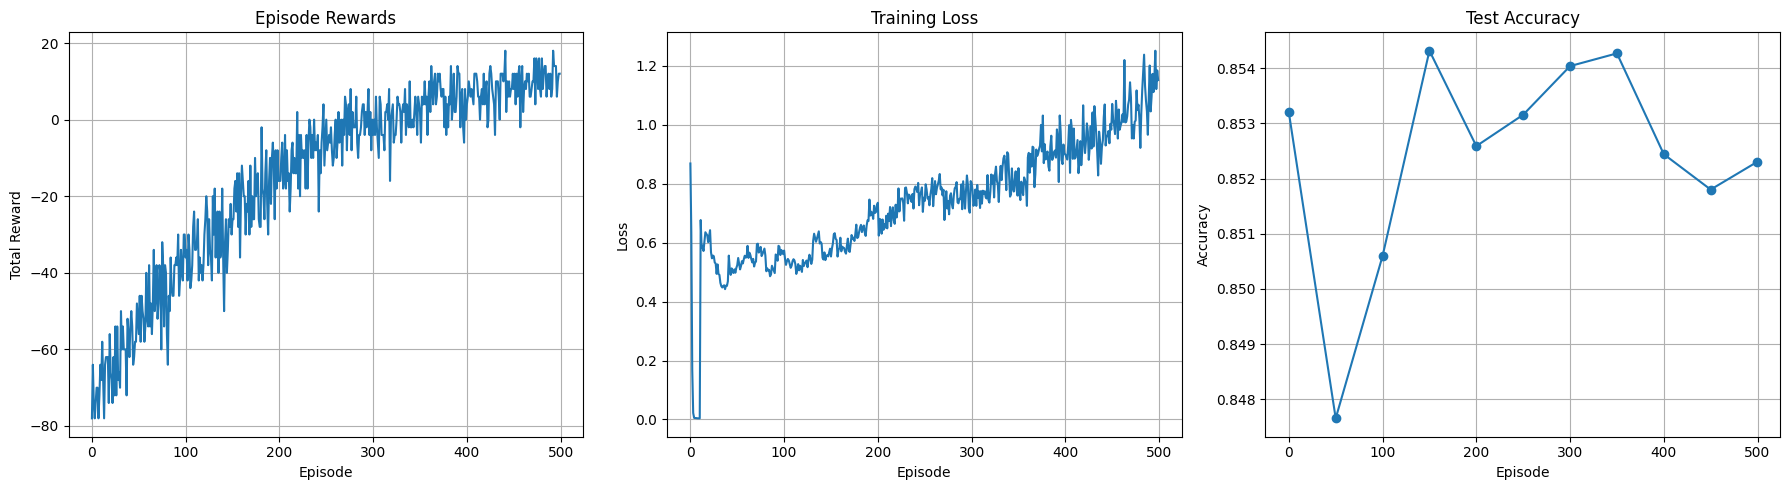

In [37]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Episode reward
axes[0].plot(episode_rewards)
axes[0].set_title('Episode Rewards')
axes[0].set_xlabel('Episode')
axes[0].set_ylabel('Total Reward')
axes[0].grid(True)

# Loss
axes[1].plot(episode_losses)
axes[1].set_title('Training Loss')
axes[1].set_xlabel('Episode')
axes[1].set_ylabel('Loss')
axes[1].grid(True)

# Test accuracy
if episode_accuracies:
    episodes, accs = zip(*episode_accuracies)
    axes[2].plot(episodes, accs, marker='o')
    axes[2].set_title('Test Accuracy')
    axes[2].set_xlabel('Episode')
    axes[2].set_ylabel('Accuracy')
    axes[2].grid(True)

plt.tight_layout()
plt.show()

In [39]:
from sklearn.metrics import confusion_matrix

# 混同行列の計算
cm = confusion_matrix(test_dataset_all.targets, predictions)

# 混同行列の可視化
print(cm)


[[318082      0      0     13    814]
 [   143      0      0      3      1]
 [ 19029      0      0      0      0]
 [ 34310      0      0      0     17]
 [   794      0      0      0      0]]


## 8. モデルの保存（オプション）

In [38]:
# 訓練済みモデルの保存
save_path = CHECKPOINT_DIR / f"rl_session{TARGET_SESSION}_dqn.pth"
save_path.parent.mkdir(parents=True, exist_ok=True)

torch.save({
    'policy_net_state_dict': policy_net.state_dict(),
    'target_net_state_dict': target_net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'session': TARGET_SESSION,
    'test_accuracy': final_test_acc,
    'hyperparameters': {
        'batch_size': BATCH_SIZE,
        'gamma': GAMMA,
        'learning_rate': LEARNING_RATE,
        'epsilon_decay': EPSILON_DECAY,
    }
}, save_path)

print(f"✓ Model saved to {save_path}")

✓ Model saved to /home/hawk/Documents/school/test/CVPR22-Fact/checkpoint/CICIDS2017_improved/rl_session1_dqn.pth


## 使用方法とカスタマイズ

### 設定の変更
- `TARGET_SESSION`: 訓練したいセッション番号（1以降）
- `freeze_encoder=True`: ベースモデルのエンコーダを凍結して新しい分類ヘッドのみ訓練
- `NUM_EPISODES`, `LEARNING_RATE`: RL訓練のハイパーパラメータ調整

### 複数セッションの連続訓練
```python
for session in range(1, NUM_SESSIONS + 1):
    TARGET_SESSION = session
    # 上記のコードを実行
    # 各セッション終了後にモデルを保存
```

### 性能改善のヒント
1. **エンコーダの凍結**: `freeze_encoder=True`で既存クラスの忘却を抑制
2. **正則化**: L2正則化やDropoutを追加
3. **リプレイバッファ**: 古いクラスのサンプルも保存して訓練
4. **Prioritized Experience Replay**: 重要なサンプルを優先的にサンプリング